# Importing Required Libraries

In the cell below we are going to import neccessary libraries

- `os`: To handle file and directory operations like listing files.
- `cv2`: OpenCV library for image loading and preprocessing.
- `numpy`: For handling arrays, matrices, and numerical operations.
- `tensorflow`: For building, training, and evaluating the CNN model.
- `matplotlib.pyplot`: For visualizing results with plots.

In [33]:
# IMPORTS
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define Constants

Defining constants below

- `IMG_SIZE`: The size to which each image will be resized.
- `IMAGE_DIR`: Path to the directory containing the images.
- `LABEL_DIR`: Path to the directory containing the label files.


In [ ]:
# Constants
IMG_SIZE = (224, 224)
IMAGE_DIR = '/TomatoPlantfactoryDataset/images'  # Update with your images folder
LABEL_DIR = '/TomatoPlantfactoryDataset/labels'  # Update with your labels folder

# Image Preprocessing Function

This function is responsible for preprocessing each image before feeding it into the CNN model. The preprocessing steps include:

1. **Resizing** the image to a uniform size defined by `IMG_SIZE`.
2. **Normalization** of pixel values to the range [0, 1] by dividing by 255.


In [35]:
# Image preprocessing function
def preprocessing_image(image):
    image = cv2.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize the image to [0, 1]
    return image

# Load Images and Labels

This function loads both images and their corresponding labels. It processes each image and extracts the tomato count from the label file. 

The function works as follows:
1. **Image Loading**: It loops through each image file in the `image_dir`, reads the image, preprocesses it, and appends it to the `images` list.
2. **Label Loading**: For each image, it tries to find a corresponding label file (with the same name but `.txt` extension). It counts the number of non-empty lines in the label file as the tomato count and appends it to the `labels` list.

The output of this function is two arrays: one containing the preprocessed images and another containing the corresponding labels (tomato counts).

In [36]:
# Load images and labels
def load_images_and_labels(image_dir, label_dir):
    images = []
    labels = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.JPG') or filename.endswith('.PNG'):
            try:
                # Image path
                img_path = os.path.join(image_dir, filename)
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not load image {img_path}")
                    continue
                image = preprocessing_image(image)
                images.append(image)

                # Label path (replace image extension with .txt for label file)
                label_filename = filename.split('.')[0] + '.txt'
                label_path = os.path.join(label_dir, label_filename)
                
                # Count tomatoes (lines in the label file)
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        count = sum(1 for line in f if line.strip())  # Count non-empty lines
                else:
                    print(f"Warning: Label file {label_path} not found.")
                    count = 0  # Default count if label file is missing

                labels.append(count)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    print("Loaded images shape:", images.shape)
    print("Loaded labels (tomato counts) shape:", labels.shape)
    
    return images, labels

# Load data
images, labels = load_images_and_labels(IMAGE_DIR, LABEL_DIR)

Loaded images shape: (520, 224, 224, 3)
Loaded labels (tomato counts) shape: (520,)


# Spilling data into training and testing sets (80% train, 20% tests)

In the below cell, the cell splits images and labels list 80-20.

In [37]:
split = int(0.8 * len(images))
train_images, test_images = images[:split], images[split:]
train_labels, test_labels = labels[:split], labels[split:]

# CNN Model Architecture

We now define the architecture of our Convolutional Neural Network (CNN). The CNN consists of:
1. **Conv2D Layers**: These layers perform convolution operations, followed by ReLU activation functions to introduce non-linearity.
2. **MaxPooling2D Layers**: These layers downsample the feature maps to reduce dimensionality.
3. **Flatten Layer**: Flattens the 2D feature maps into a 1D array for the fully connected layers.
4. **Dense Layers**: These layers are fully connected layers. The last dense layer has one neuron with a linear activation function to predict the tomato count.

The CNN Layer is represented as:
$\text{F} = σ(\text{I}*\text{K}+\text{B})$  $\text{P} = \text{Pool}(\text{F})$

## Convolutional Layer
The **Convolutional Layer** is a core layer in building a Convolutional Neural Network (CNN). This CNN layer is designed to automatically and adaptively learn spatial hierarchies in an image.
The convolutional operation is mathematically represented as:

$S(i,j)=(I∗F)(i,j)= m∑​n∑​I(i+m,j+n)⋅F(m,n)$

Where,
- $S(i,j)$ is the output of the feature map
- $I$ is input image
- $F$ is the filter (Kernels)
- $(i,j)$ represents pixels coordinates
- $(m,n)$ represents the area of the filter

### Actication Function
Here the activation function **ReLU** is used to introduce non-linearity. 

Mathematical representation of ReLu:
$\text{ReLU}(x) = \text{max}(0,x)$

### Use of this layer
Convoltuional layers helps the network to focus on small, local features (edges, textures) without needing the entire image at once. They are key to identifying important patterns in images, making them ideal for computer vision tasks like object detection.

## MaxPooling Layer
The **MaxPooling Layer** is a down-sampling operation that reduces the spatial dimensions (height and width) of the feature maps. MaxPooling is typically used after convolution layers to reduce the number of parameters, computations, and the potential overfitting of the model.

MaxPooling Layer is mathematically represented as:

$\text{MaxPool}(x) = \max_{i,j \in p \times p} (x_{i,j})$.

Where,
- $x$ is the input matrix
- $PxP$ represents pooling window

### Use of this layer
MaxPooling allows the model to become more invariant to small translations, rotations, and distortions in the image. It also reduces the spatial dimensions, thus reducing computation and making the model more efficient.

## Flatten Layer
The **Flatten Layer** takes the output from the previous layers (which is typically a 2D or 3D array of values) and reshapes it into a 1D vector. This is done because fully connected layers expect 1D input vectors.

For a feature map of size $𝐻×𝑊×𝐷$ the Flatten operation converts it into a vector of size $𝐻×𝑊×𝐷$. Mathematically:

$\text{Flattened Vector} = [X_1, X_2, X_3]$

where,
- n = $𝐻×𝑊×𝐷$, representing the total number of elements in the flattened vector.

### Use of this layer
Flattening prepares the extracted features (from the convolution and pooling layers) for input to the fully connected (dense) layers, where decisions or predictions will be made.

## Fully Connected Dense Layer
The **Fully Connected Dense Layer** (or Dense Layer) takes the flattened output and computes a weighted sum of the inputs, followed by the application of an activation function. 

The Dense Layer mathematically defined as:

$\text{y} = {W}.x + B$

where,
- $y$ output vector
- $W$ is the weights
- $x$ output of the previous layers
- $B$ is the bias

### Actication Function
Here the activation function **ReLU** is used to introduce non-linearity. 

Mathematical representation of ReLu:
$\text{ReLU}(x) = \text{max}(0,x)$

### Use of this layer
Fully connected layers are responsible for combining the features learned by previous layers and making decisions based on these features. For regression tasks, the final layer outputs a continuous value (count of tomatoes), and hence a linear activation function is used.

## Output Layer
The **output layer** which is again a **Dense Layer** with a single neuron is used to predict the tomato. This output layer uses linear activation function

In [38]:
# CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),  # Output layer for count prediction
])

# Compile the Model

In this section, we compile the CNN model by specifying:
- **Optimizer**: Adam optimizer with a learning rate of 0.001.
- **Loss Function**: Mean Squared Error (MSE) because the task is a regression (count prediction).
- **Metrics**: Mean Absolute Error (MAE) is used to monitor the model’s performance during training.

## Loss Function: Mean Squared Error (MSE):
The **Mean Squared Error** is the most commonly used loss function for regression tasks. It computes the average squared difference between the predicted values and the actual values.

$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{true},i} - y_{\text{pred},i})^2 $

where,
- $(y_{\text{true},i})$ is the actual count of tomatoes in the *i*-th image
- $y_{\text{pred},i})$ is the predicted count of tomatoes
- *N* is the number of data points in the dataset

### Why MSE
MSE penalizes larger errors more heavily, which helps the model learn to predict values that are as close as possible to the true values. It is ideal for tasks that involve continuous output values like regression.

## Adam Optimizer
The **Adam Optimizer** is used to update the weights of the network during training. It combines the benefits of both **AdaGrad** and **RMSProp**.

The update rule for ADAM is:
$\theta_t = \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

Where,
- $\theta_t$ is the parameter (weights) at the time *t*
- $\eta$ is the learning rate
- $\hat{m}_t$ is the estimate of the first moment (mean)
- $\hat{v}_t$ is the estimate of the second moment (variance)
- $\epsilon$ is a small constant to prevent division by zero

In [39]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mae'])

# Train the Model

Here, we train the CNN using the training data (`train_images` and `train_labels`). We use 20 epochs and a batch size of 32.


In [40]:
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                    epochs=20, batch_size=32)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 606.1127 - mae: 18.9035 - val_loss: 59.2165 - val_mae: 6.5001
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - loss: 89.5947 - mae: 7.2653 - val_loss: 59.4320 - val_mae: 6.5254
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - loss: 73.5672 - mae: 6.1997 - val_loss: 46.3389 - val_mae: 5.3611
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - loss: 78.3262 - mae: 5.8936 - val_loss: 39.4124 - val_mae: 4.8284
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - loss: 36.6427 - mae: 4.5621 - val_loss: 58.5355 - val_mae: 6.1321
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - loss: 37.2343 - mae: 4.5000 - val_loss: 34.7880 - val_mae: 4.5294
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - loss: 23.7668 - mae: 3.5791 - val_loss: 33.1304 - val_mae: 4.4730
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 12.9825 - mae: 2.7429 - val_loss: 33.5902 - val_mae: 4.4690
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 

# Model Evaluation

Once training is complete, we evaluate the model’s performance on the testing set using:
- **Test MAE**: Mean Absolute Error on the test set.
- **RMSE**: Root Mean Squared Error between predicted and actual counts, to quantify the model’s error.


In [41]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)
rmse = np.sqrt(np.mean((predictions - test_labels) ** 2))

# Print evaluation results
print(f"Test MAE: {test_mae}")
print(f"RMSE: {rmse}")
print(f'Traning Loss: {history.history['loss']}')
print(f'Validation Loss: {history.history['val_loss']}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 30.4735 - mae: 4.2576
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Test MAE: 4.379888534545898
RMSE: 10.31075763707318
Traning Loss: [387.66998291015625, 98.37688446044922, 76.74175262451172, 60.529273986816406, 40.23836135864258, 32.578861236572266, 21.79975700378418, 12.22260856628418, 7.184514045715332, 5.301908493041992, 3.277301549911499, 1.975650668144226, 1.2035231590270996, 0.7640159130096436, 0.5434426069259644, 0.36863869428634644, 0.26260045170783997, 0.21368050575256348, 0.19989551603794098, 0.1857776939868927]
Validation Loss: [59.21653747558594, 59.4320068359375, 46.338924407958984, 39.412410736083984, 58.53549575805664, 34.78800582885742, 33.13043975830078, 33.590232849121094, 37.48861312866211, 32.12357711791992, 30.987520217895508, 31.298227310180664, 31.853105545043945, 31.721149444580078, 32.094459533691406, 31.30583381652832, 31.864614486694336, 32.46099853515625, 32.42734146118164, 31.758777618408203]


# Visualizations

In this section, we visualize the training and validation loss over epochs, as well as the comparison between actual and predicted tomato counts.

- **Loss curves**: We plot the training and validation loss to monitor the model’s learning process.
- **Scatter plot**: A scatter plot of the actual vs predicted counts to visualize how well the model is performing.


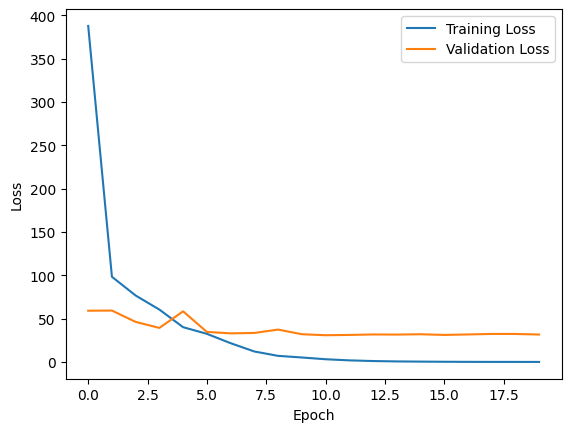

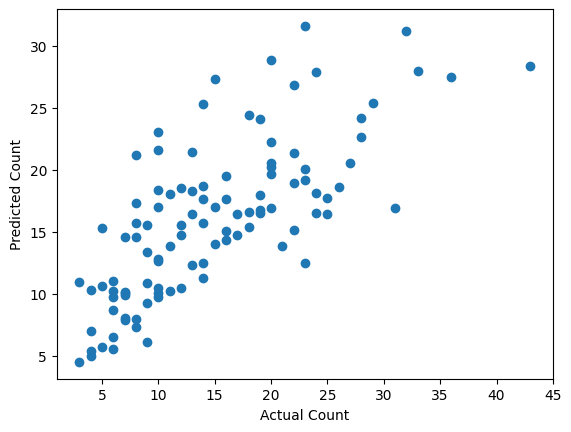

In [42]:
# Visualizations
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted counts
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.show()

# Model Result

### Test MAE (Mean Absolute Error)
The MAE is around 4.38 which is a bit off but relatively good depending on the scale of target variable.

### Test RMSE (Root Mean Square Error)
The RMSE gives a sense of how much error there is between the model's prediction and actual outcomes. A higher RMSE suggests larger errors, while a lower value suggests that the model is doing better. 10.31 indicates moderate error in the model's predictions, with outliers having a larger influence on the RMSE.

### Training loss
The training loss is steadily decreasing, starting from 387.67 and gradually approaching values close to zero. This shows that the model is effectively learning from the data and is improving its predictions over time.

### Validation Loss
The validation loss fluctuates between 30 and 59, but it doesn't show a consistent decrease as the training loss does.
Which could mean,

- **Overfitting:** The model is learning well on the training set, but it might not generalize well to unseen data. The gap between training and validation loss is an indicator of this.